In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist



In [8]:
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
# Load the tweets dataset
tweets = pd.read_csv('/content/translated_tweets.csv')

# Concatenate all the tweets into a single string
tweets_str = ' '.join([str(tweet) for tweet in tweets['Translated_Tweet'].tolist()])

# Tokenize the tweets string
tokens = word_tokenize(tweets_str)

# Compute the frequency distribution of the tokens
freq_dist = FreqDist(tokens)

In [10]:
tweets=tweets.drop(['Tweet'], axis=1)

In [12]:
tweets


Date             User  \
0     2023-04-11 05:06:06+00:00        btkamu111   
1     2023-04-11 04:32:00+00:00  AdityaN59800330   
2     2023-04-11 01:28:15+00:00    Rkumar1993may   
3     2023-04-10 14:17:00+00:00       pw__skills   
4     2023-04-10 12:56:21+00:00    ____yogesh___   
...                         ...              ...   
4771  2019-08-11 15:06:03+00:00       stay_mad__   
4772  2019-01-10 18:34:24+00:00  Invention_INDIA   
4773  2019-01-09 15:53:32+00:00  Invention_INDIA   
4774  2018-11-29 01:13:21+00:00  Sushils28455718   
4775  2018-08-18 06:52:59+00:00    Sadid55435442   

                                       Translated_Tweet  
0     By closing one tap, the pin is leaking, when t...  
1     sir please launch clat batch asap want prepare...  
2     How much trouble will you have to face on the ...  
3     techie dont agree failure ingredient success p...  
4           server kara diye physicswallah pwserverdown  
...                                                 ...  
4771  anything unsubscribe physics wallah physics wa...  
4772  top channel medical neet preparation mbbs biol...  
4773  top channel medical neet preparation mbbs biol...  
4774  tribute teacher providing free education made ...  
4775                                      physicswallah  

[4776 rows x 3 columns]

In [15]:
from sklearn.model_selection import train_test_split
test,train= train_test_split(tweets,test_size=0.2)

In [16]:
import pandas as pd
from textblob import TextBlob

# load the tweets csv into a pandas dataframe
#tweets = pd.read_csv('tweets.csv')

# convert the tweet column to string
train['Translated_Tweet'] = train['Translated_Tweet'].astype(str)

# define a function to get the sentiment of a tweet
def get_sentiment(tweet):
    blob = TextBlob(tweet)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'

# apply the get_sentiment function to the tweet column and create a new column for sentiment
train['sentiment'] = train['Translated_Tweet'].apply(get_sentiment)

# display the tweets dataframe with the sentiment column
print(tweets.head())

                        Date             User  \
0  2023-04-11 05:06:06+00:00        btkamu111   
1  2023-04-11 04:32:00+00:00  AdityaN59800330   
2  2023-04-11 01:28:15+00:00    Rkumar1993may   
3  2023-04-10 14:17:00+00:00       pw__skills   
4  2023-04-10 12:56:21+00:00    ____yogesh___   

                                    Translated_Tweet  
0  By closing one tap, the pin is leaking, when t...  
1  sir please launch clat batch asap want prepare...  
2  How much trouble will you have to face on the ...  
3  techie dont agree failure ingredient success p...  
4        server kara diye physicswallah pwserverdown  


In [18]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.7 MB/s eta 0:00:00


In [21]:
import pandas as pd
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import BertTokenizer, BertModel

train['Translated_Tweet'] = train['Translated_Tweet'].astype(str)
test['Translated_Tweet'] = test['Translated_Tweet'].astype(str)
# Define the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define the training data
train_texts = train['Translated_Tweet'].tolist()
train_labels = train['sentiment'].tolist()

# Convert the text data to numerical features using BERT
train_features = []
for text in train_texts:
    encoded_text = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
    input_ids = encoded_text['input_ids']
    attention_mask = encoded_text['attention_mask']
    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)
    features = output[0].mean(dim=1).squeeze().tolist()
    train_features.append(features)

# Define the test data
test_texts = test['Translated_Tweet'].tolist()

# Convert the text data to numerical features using BERT
test_features = []
for text in test_texts:
    encoded_text = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
    input_ids = encoded_text['input_ids']
    attention_mask = encoded_text['attention_mask']
    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)
    features = output[0].mean(dim=1).squeeze().tolist()
    test_features.append(features)

# Train an SVM model on the training data
svm_model = svm.SVC(kernel='linear')
svm_model.fit(train_features, train_labels)

# Use the trained model to predict stress levels for the test data
predicted_labels = svm_model.predict(test_features)

# Print the predicted stress levels for each test text
for i in range(len(test_texts)):
    print('Text: ' + test_texts[i] + '\tPredicted sentiment: ' + str(predicted_labels[i]))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text: nan	Predicted sentiment: neutral
Text: nan	Predicted sentiment: neutral
Text: paray physicswallaha thanks to alakh pandey sir hanhar teacher lin ki chih v tarun sir h md sir thath chemistry ki jugad y ritak sir and his ritrick physicswallah physicswallh	Predicted sentiment: neutral
Text: Bhaiya __wallah please and you both sit with each other in this solvay kegi jadukijheppi edtechrevolution _ fasiksualallah pavimotion	Predicted sentiment: neutral
Text: marrow pre doctutorials cerebellum dam neetpg wallah neetpg2023postponement medtwitter physicswallah	Predicted sentiment: negative
Text: bsf foled conspracy pakistani terrorists jammu border sent ed childrens tiffin thr0ugh drone defused security personnel alert bsf tejran arjun kapoor physicswallah ektakapoor	Predicted sentiment: positive
Text: physicswallah challenging gravity low funding day	Predicted sentiment: negative
Text: techie ultimate roadmap code like pro pw pwskills physicswallah coder ultimate roadmap programmer tech

In [22]:
(predicted_labels)

['neutral' 'neutral' 'neutral' ... 'positive' 'neutral' 'neutral']


In [23]:
from collections import Counter

# words = ['neutr', 'b', 'c', 'a']

Counter(predicted_labels).keys() # equals to list(set(words))
Counter(predicted_labels).values()

dict_values([2001, 378, 1441])

In [26]:
test['pred_sentiment'] = predicted_labels

In [30]:
list2 = ['nan']
test = test[test.Translated_Tweet.isin(list2) == False]

In [31]:
test

Date             User  \
2530  2022-10-18 17:26:25+00:00  Shubham84870799   
2363  2022-10-31 15:11:10+00:00       i_m_mazid_   
1225  2023-01-27 15:51:48+00:00   aspirin_325_mg   
4296  2022-06-07 13:30:53+00:00       IQueenBee2   
586   2023-03-23 05:56:59+00:00  WeekendInvestng   
...                         ...              ...   
3410  2022-07-07 16:52:39+00:00        Puru_here   
1244  2023-01-24 15:36:00+00:00       educatoraj   
1796  2022-12-15 17:51:07+00:00    Sivaprasanth5   
3705  2022-06-09 13:53:11+00:00       taxologyin   
709   2023-03-16 03:29:23+00:00   Indiandoctor2w   

                                       Translated_Tweet pred_sentiment  
2530  paray physicswallaha thanks to alakh pandey si...        neutral  
2363  Bhaiya __wallah please and you both sit with e...        neutral  
1225  marrow pre doctutorials cerebellum dam neetpg ...       negative  
4296  bsf foled conspracy pakistani terrorists jammu...       positive  
586   physicswallah challenging gravity low funding day       negative  
...                                                 ...            ...  
3410           Alakh Sir True Karma Yogi Fasiksualallah        neutral  
1244  answer आप बत सकत ह short shortsytindia reel re...        neutral  
1796  week release ott 12 prime halfpantsfullpants p...       positive  
3705  startup news edtech startup physicswallah rais...        neutral  
709     neetug2023 neetpg2023 physicswallah watch video        neutral  

[3474 rows x 4 columns]

<Axes: xlabel='pred_sentiment', ylabel='count'>

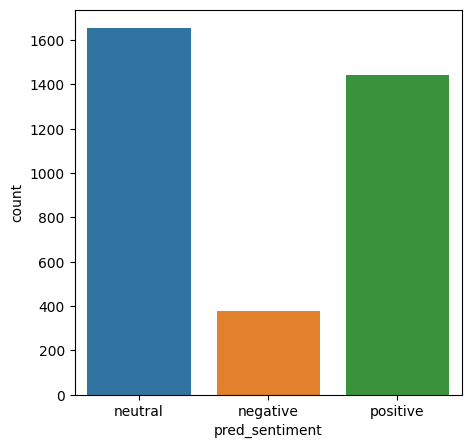

In [35]:
import matplotlib.pyplot as plt
import seaborn  as sns
fig = plt.figure(figsize=(5,5))
sns.countplot(x='pred_sentiment',data =test)


Text(0.5, 1.0, 'Distribution of sentiments')

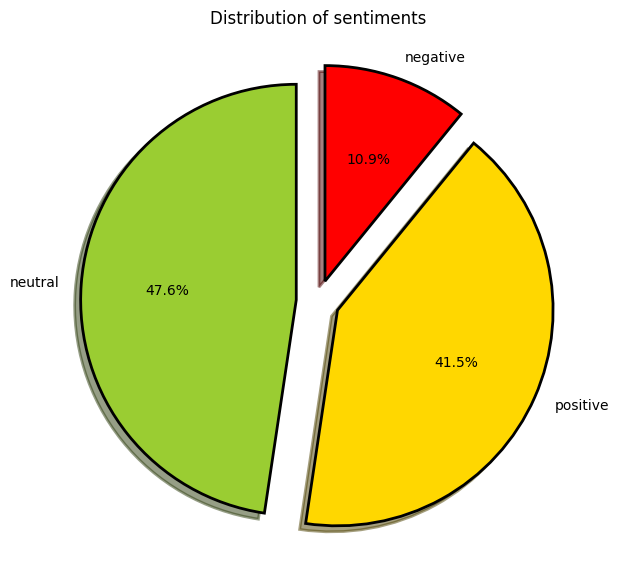

In [37]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = test['pred_sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [41]:
pos_tweets = test[test.pred_sentiment == 'positive']
pos_tweets.head()

Date             User  \
4296  2022-06-07 13:30:53+00:00       IQueenBee2   
1320  2023-01-12 04:42:02+00:00     its_me_naina   
1402  2023-01-02 19:02:56+00:00    _swiftyhazal_   
4658  2021-02-21 16:28:22+00:00  Akshayr02134805   
4490  2022-03-21 06:16:21+00:00        PwLucknow   

                                       Translated_Tweet pred_sentiment  
4296  bsf foled conspracy pakistani terrorists jammu...       positive  
1320  sir mohammed asim sir continue take daily curr...       positive  
1402  certain thing life uncertainty try run away un...       positive  
4658  alak sir great person also talented good physi...       positive  
4490  creation world also added increase beauty worl...       positive

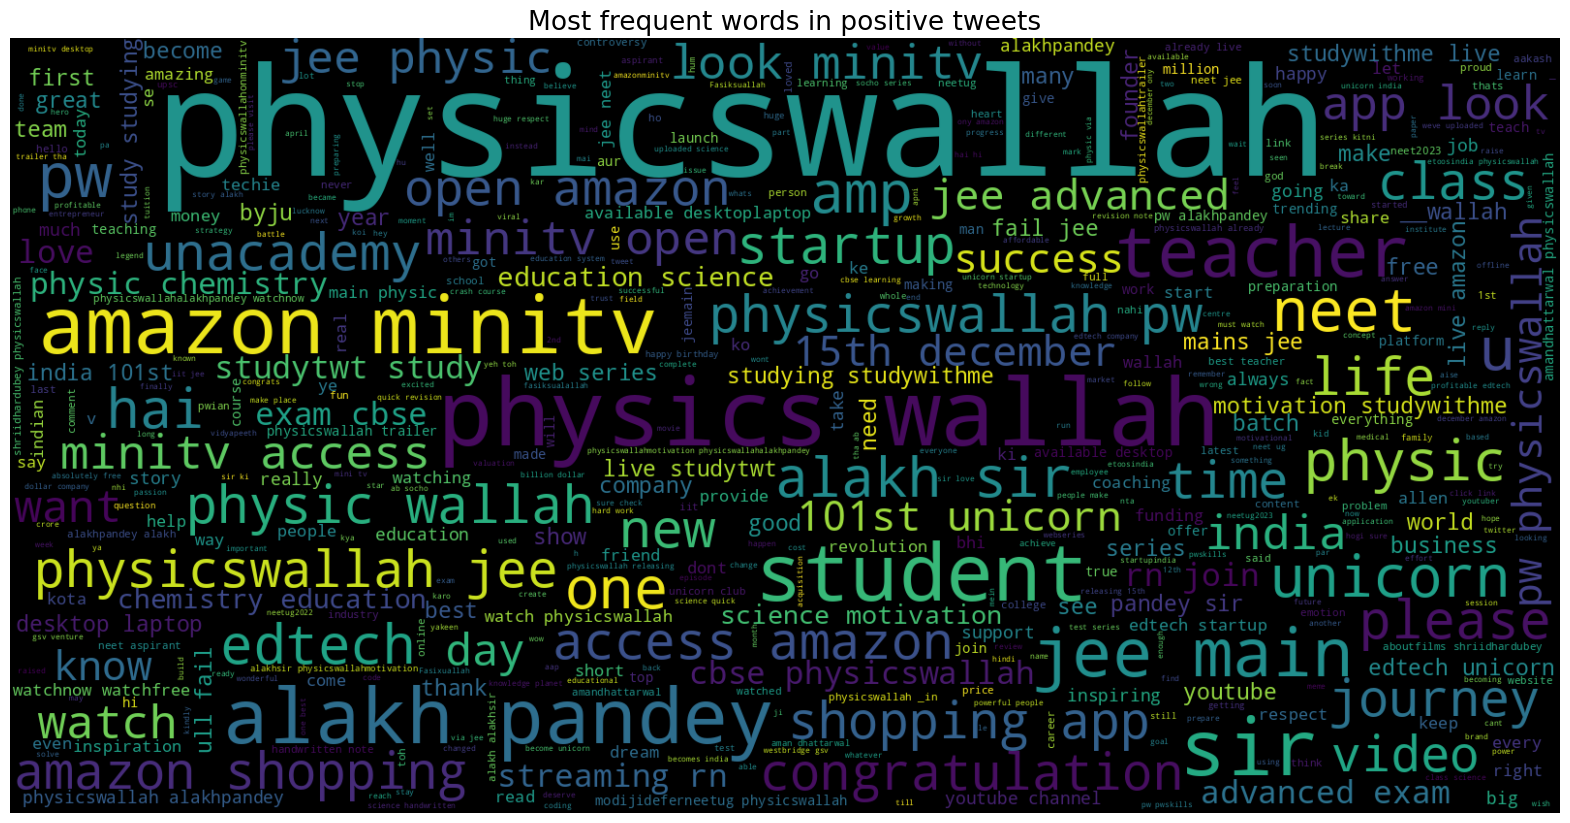

In [44]:
from wordcloud import WordCloud
text = ' '.join([word for word in pos_tweets['Translated_Tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [45]:
neg_tweets = test[test.pred_sentiment == 'negative']

neg_tweets.head()

Date             User  \
1225  2023-01-27 15:51:48+00:00   aspirin_325_mg   
586   2023-03-23 05:56:59+00:00  WeekendInvestng   
625   2023-03-21 10:33:54+00:00       pw__skills   
2750  2022-09-16 18:17:04+00:00     IMetaversity   
228   2023-03-28 07:10:27+00:00   BalajiJayaram4   

                                       Translated_Tweet pred_sentiment  
1225  marrow pre doctutorials cerebellum dam neetpg ...       negative  
586   physicswallah challenging gravity low funding day       negative  
625   techie ultimate roadmap code like pro pw pwski...       negative  
2750  many video physicswallah allen student fightin...       negative  
228   harsh workplace physicswallah negative impact ...       negative

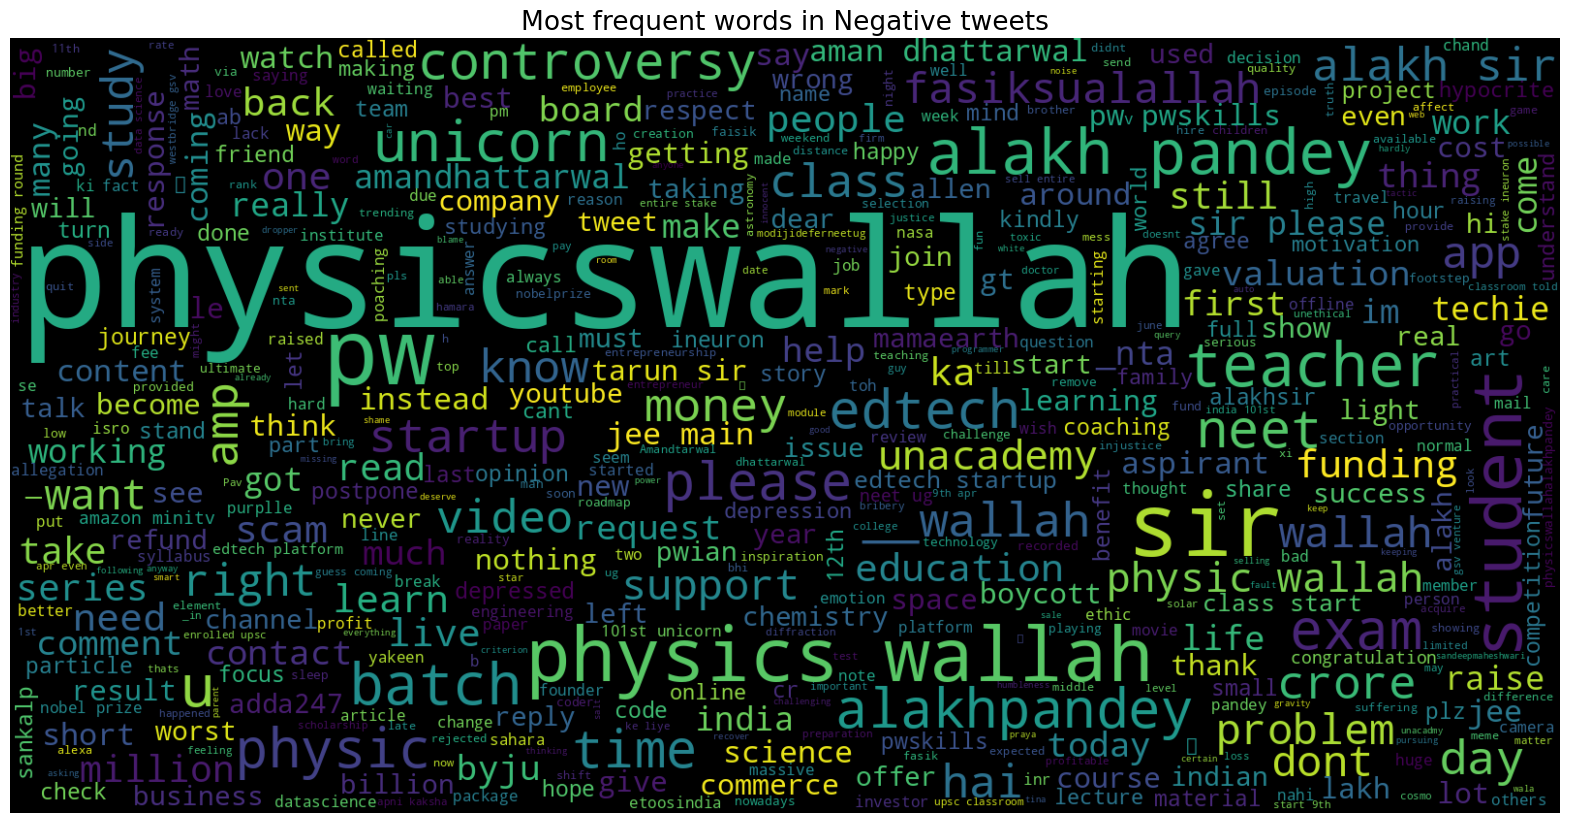

In [49]:
from wordcloud import WordCloud
text = ' '.join([word for word in neg_tweets['Translated_Tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in Negative tweets', fontsize=19)
plt.show()

In [47]:
neutral_tweets = test[test.pred_sentiment == 'neutral']

neutral_tweets.head()

Date             User  \
2530  2022-10-18 17:26:25+00:00  Shubham84870799   
2363  2022-10-31 15:11:10+00:00       i_m_mazid_   
3679  2022-06-10 14:06:49+00:00        ecelliitg   
1038  2023-02-22 12:40:11+00:00     desitrolls14   
3794  2022-06-08 11:31:04+00:00       JagranNews   

                                       Translated_Tweet pred_sentiment  
2530  paray physicswallaha thanks to alakh pandey si...        neutral  
2363  Bhaiya __wallah please and you both sit with e...        neutral  
3679  dropping teaching million 101st unicorn story ...        neutral  
1038                         desitrolls14 physicswallah        neutral  
3794  75 kard ka nikar chad in rs 5000 why children ...        neutral

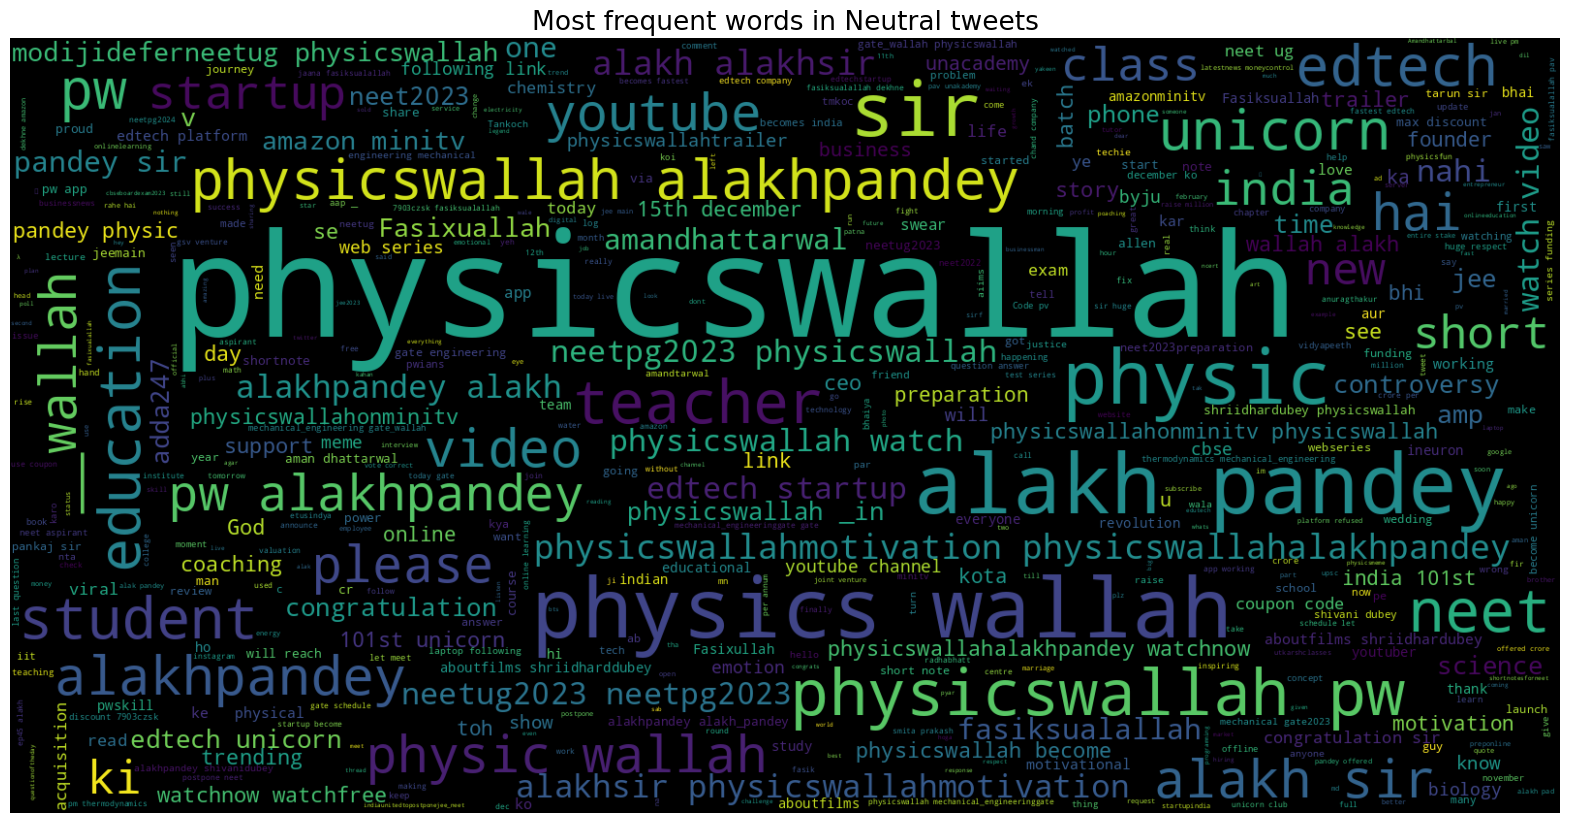

In [50]:
from wordcloud import WordCloud
text = ' '.join([word for word in neutral_tweets['Translated_Tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in Neutral tweets', fontsize=19)
plt.show()

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(1,2)).fit(test['Translated_Tweet'])

In [54]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 39218

First 20 features:
 ['00' '00 am' '00 pm' '01' '01 2023' '01 am' '0111' '0111 gate'
 '01141036554' '01141036554 saketinstitute' '02' '02 2022' '02 2023'
 '0200pm' '0200pm shortnot' '0200pm shortnotesforneet' '03' '03 2023'
 '03 hour' '04']


In [56]:
X = test['Translated_Tweet']
Y = test['pred_sentiment']
X = vect.transform(X)

In [57]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [58]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (2779, 39218)
Size of y_train: (2779,)
Size of x_test: (695, 39218)
Size of y_test: (695,)


In [59]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))


Test accuracy: 72.09%


In [62]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[  8  36  28]
 [  4 296  35]
 [  1  90 197]]


              precision    recall  f1-score   support

    negative       0.62      0.11      0.19        72
     neutral       0.70      0.88      0.78       335
    positive       0.76      0.68      0.72       288

    accuracy                           0.72       695
   macro avg       0.69      0.56      0.56       695
weighted avg       0.72      0.72      0.69       695



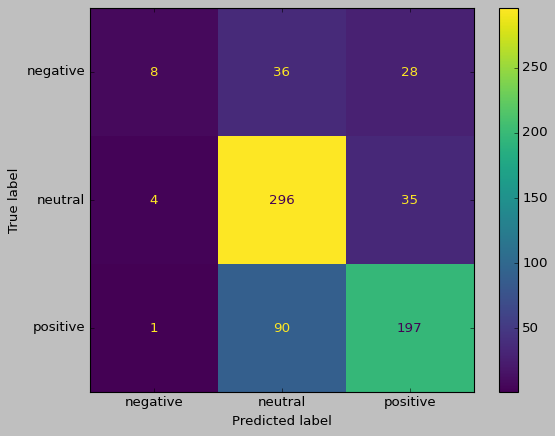

In [64]:
from matplotlib import style
style.use('ggplot')

style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

In [65]:
from sklearn.model_selection import GridSearchCV

In [66]:
param_grid={'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [67]:
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 0.1}


In [68]:
y_pred = grid.predict(x_test)

In [69]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 70.22%


In [70]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))


[[  3  40  29]
 [  2 302  31]
 [  0 105 183]]


              precision    recall  f1-score   support

    negative       0.60      0.04      0.08        72
     neutral       0.68      0.90      0.77       335
    positive       0.75      0.64      0.69       288

    accuracy                           0.70       695
   macro avg       0.68      0.53      0.51       695
weighted avg       0.70      0.70      0.67       695



In [71]:
from sklearn.svm import LinearSVC

In [72]:

SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

LinearSVC()

In [73]:
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("test accuracy: {:.2f}%".format(svc_acc*100))

test accuracy: 70.79%


In [74]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[  9  35  28]
 [  5 294  36]
 [  6  93 189]]


              precision    recall  f1-score   support

    negative       0.45      0.12      0.20        72
     neutral       0.70      0.88      0.78       335
    positive       0.75      0.66      0.70       288

    accuracy                           0.71       695
   macro avg       0.63      0.55      0.56       695
weighted avg       0.69      0.71      0.68       695



In [75]:
grid = {
    'C':[0.01, 0.1, 1, 10],
    'kernel':["linear","poly","rbf","sigmoid"],
    'degree':[1,3,5,7],
    'gamma':[0.01,1]
}
grid = GridSearchCV(SVCmodel, param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [76]:
print("Best parameter:", grid.best_params_)

Best parameter: {'C': 0.1}


In [77]:
y_pred = grid.predict(x_test)

In [78]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 70.36%


In [79]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[  8  38  26]
 [  4 298  33]
 [  3 102 183]]


              precision    recall  f1-score   support

    negative       0.53      0.11      0.18        72
     neutral       0.68      0.89      0.77       335
    positive       0.76      0.64      0.69       288

    accuracy                           0.70       695
   macro avg       0.66      0.55      0.55       695
weighted avg       0.70      0.70      0.68       695

